<a href="https://colab.research.google.com/github/aissahm/image_analysis/blob/main/project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image analysis - Project 1**

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

## **Introduction**

In this task we will evaluate the potential of three image operators, when used in sequence, to extract image features suitable for license plate image detection (i.e., features that must highlight the caracters of a plate). In the current directory, you will find the images of the plates and their binary masks. You will also find three random splits of the original images into training and testing sets. The task consists of the following steps, which can be applied to any of these sets.

1. Step 1: Dataset composition.
2. Step 2: Batch (z-score) normalization.
3. Step 3: Creation of a random kernel bank.
4. Step 4: Convolution with the random kernel bank. 
5. Step 5: Rectified Linear Unit activation (ReLU).

These steps are presented in the next sections.

## **Dataset composition**

You must create a subimage (patch) dataset by extracting regions of interest with size W × H pixels, center at each position (x,y) of the original images, and stride (displacement between them) of (Dx,Dy) pixels.

The plate masks (avaliable annotation) can be used in this step only to verify if your choice for W, H, Dx, and Dy is suitable to not miss any plate from the training set. That is, for the corresponding testing set, you will simply use the same parameters learned in the training set.

In this step, using the training set only, you must also define a threshold on the percentage of plate pixels that fall inside a subimage to consider it from class 1 (background) or class 2 (plate/foreground). Note that this will create a difficulty for a future plate detection since subimages with parts of a plate might be considered background. In this sense, we might need to further process those images in the future to avoid classification errors.

After creating the subimages of a same size W × H, you must convert each subimage into a multiband image by pseudo colorizing it based on a Red-Green-Blue color table (e.g., from blue to red) and then convert it into an uncorrelated color space (e.g., Y-Cb-Cr or L-a-b).


**We first create a function that returns the percentage of plate pixels contained in a subimage**

We need the sizes W x H, the coordinates of the center of the subimage (x,y).

In [67]:
#returns the number of pixels representing
#the plate in the mask
def returnPlateNumberPixelsFromMask(maskImg):
  #maskImg = cv2.imread(maskPath)
  return maskImg.sum()/(3*255)

#given width x height, and center coordinates of subimage,
#returns number of plate pixels contained in subimage
def returnPlateNumberPixelsCovBySubimage(width, height, xcenter, ycenter, maskImg):
  xstart = xcenter - width//2
  xend = xcenter + width//2
  ystart = ycenter - height//2
  yend = ycenter + height//2
  subImg = maskImg[ystart:yend+1,xstart: xend+1,:]

  return subImg.sum()/(3*255)

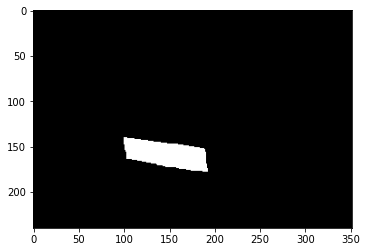

In [13]:
test_image_path = "/content/plates/mask_0001.png"

#Import image
img = cv2.imread(test_image_path)

#Show the image with matplotlib
plt.imshow(img)
plt.show()

In [14]:
w = 150
h = 100
x = 150
y = 150

print(returnPlateNumberPixelsCovBySubimage(w, h, x, y, img))
print()
print(returnPlateNumberPixelsFromMask(img))

2274.0

2274.0


In [66]:
def scanOriginalImageUsingSubImagesWith(width, height, xstride, ystride, imagepath, thresholdForPlateClass):
  
  imageToScan = cv2.imread(imagepath)
  plateNumberPixelsInImageToScan = returnPlateNumberPixelsFromMask(imageToScan)

  #statistics
  numberSubImages = 0
  numberSubImagesClassPlate = 0 #number of images wich contain the threshold of plate percentage
  numberSubImagesContainingAllPlate = 0

  #initializing scanning parameters 
  xcenter_initial = width // 2
  ycenter_initial = height // 2
  yfinal = imageToScan.shape[0] - height // 2 - 1
  xfinal = imageToScan.shape[1] - width // 2 - 1
  ycenter = ycenter_initial
  xcenter = xcenter_initial
  
  #we scan the original image from left to right, top to bottom
  while ycenter <= yfinal:
    
    #We make sure we cover the entire original image 
    #on the last strides on vertical and/or horizontal axes
    if xfinal - xcenter < xstride:
      xcenter = xfinal
    if yfinal - ycenter < ystride:
      ycenter = yfinal
    
    plateNumberPixelsInSubimage = returnPlateNumberPixelsCovBySubimage(width, height, xcenter, ycenter, imageToScan)
    platePercentageCovered = plateNumberPixelsInSubimage / plateNumberPixelsInImageToScan
    
    #Increment
    xcenter += xstride
    if xcenter > xfinal:
      xcenter = xcenter_initial
      ycenter += ystride
    
    #statistics
    numberSubImages += 1
    if platePercentageCovered >= thresholdForPlateClass:
      numberSubImagesClassPlate += 1
    if platePercentageCovered == 1.0:
      numberSubImagesContainingAllPlate += 1
    
  #print statistics:
  #print("Number of subimages created ", numberSubImages - 1)
  #print("Number of subimages with threshold pixels of plate ", numberSubImagesClassPlate)
  #print("Number of subimages containing all the plate ", numberSubImagesContainingAllPlate)

  return [numberSubImagesContainingAllPlate, numberSubImagesClassPlate, numberSubImages]

We test the functions created above with one example before looping through all the 3 training sets.

In [ ]:
w = 151
h = 51
dx = 40
dy = 10
test_image_path = "/content/plates/mask_0001.png"

threshold = 0.9

scanOriginalImageUsingSubImagesWith(w, h, dx, dy, test_image_path, threshold)

[2, 6, 114]

Now that everything is working as expected, we create an array containing the path to the masks to perform the tests on the entire training sets. 

In [ ]:
#given a text file containing the name of training images
#return pathfile of respective masks
def returnMaskImagesPathArray(trainTextPath):
  mask_images_path_array = []
  train_images_array = []
  with open(trainTextPath, 'r') as file:
      data = file.read().replace('\n', ';')
      train_images_array = data.split(";")
  for train_image_str in train_images_array:
    mask_image_str = train_image_str.replace("./plates/orig", "/content/plates/mask")
    if len(mask_image_str) > 0:
      mask_images_path_array.append(mask_image_str)

  return mask_images_path_array

We select manually the values of W, H, Dx, Dy. 

We define the variable "threshold" as the percentage of pixels from the plate contained in a subimage to classify the subimage as class 2 "plate". If the percentage is below that threshold, we classify the subimage as belonging to class 1 "background".

In [ ]:
w = int(175 * 1.1)
h = int(75 * 1.1)
dx = 40
dy = 10
threshold = 0.9

totalNumberSubimagesCreated = 0
totalNumberImagesWithPlatesNotCovered = 0
listTrainImagesWithPlatesNotCovered = []

mask_images_path_array = returnMaskImagesPathArray("/content/train1.txt")

for train_mask_imagepath in mask_images_path_array:
  nImagesContainingAllPlate, nImagesClassPlate, nTotalSubimages = scanOriginalImageUsingSubImagesWith(w, h, dx, dy, train_mask_imagepath, threshold)
  totalNumberSubimagesCreated += nTotalSubimages

  if nImagesContainingAllPlate == 0:
    totalNumberImagesWithPlatesNotCovered += 1
    listTrainImagesWithPlatesNotCovered.append(train_mask_imagepath)
  
  #print("nImagesContainingAllPlate ", nImagesContainingAllPlate)
  #print("nImagesClassPlate ", nImagesClassPlate)
  #print("Total Subimages created", nTotalSubimages)
  #print()

print("Training set size: ", len(mask_images_path_array))
print("Total number images without plates found: ", totalNumberImagesWithPlatesNotCovered)
print("Total subimages created from training set: ", totalNumberSubimagesCreated)


Training set size:  100
Total number images without plates found:  0
Total subimages created from training set:  6400


Runnning various values of the parameters, we get the following minimal values in order to make sure that we have at least one subimage of class 2 from each original image, as well as at least one subimage containing the entire plate inside it.



Parameters:

First training set: w = 170, h = 70, dx = 40, dy = 10, threshold = 0.9

Second training set: w = 170, h = 70, dx = 40, dy = 10, threshold = 0.9

Third training set: w = 170, h = 75, dx = 40, dy = 10, threshold = 0.9




In order to increase the chances of success of getting at least one subimage containing the plate with the minimum threshold on the test sets, we increase by 10% the values of W and H. This will also allow us to decrease the total number of subimages from all images from 8500 to 6400. 

Conclusion:

1. W = int(175 * 1.1) = 187 pixels
2. H = int(75  * 1.1) = 77 pixels

3. Dx = 40 pixels
4. Dy = 10 pixels


In [ ]:
#save parameters in param.txt


### **Converting the subimages to Y-Cb-Cr format** 

Now, we must convert each subimage into a multiband image by pseudo colorizing it based on a Red-Green-Blue color table (e.g., from blue to red) and then convert it into an uncorrelated color space (e.g., Y-Cb-Cr or L-a-b).

original image shape:  (240, 352, 3)
YCbCr Subimage shape:  (76, 221, 3)


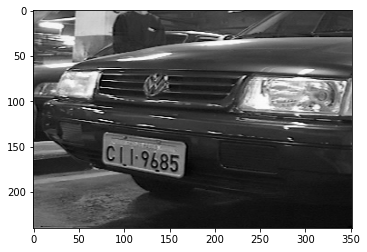

In [53]:
img = cv2.imread('/content/plates/orig_0037.png', 1)
print("original image shape: ", img.shape)

imgYCrCb = cv2.cvtColor(img[120+0:120+76, 5+0:50+176,:], cv2.COLOR_RGB2YCrCb)
print("YCbCr Subimage shape: ", imgYCrCb.shape)

plt.imshow(img)
plt.show()

## **Creating all the subimages from the training sets**

In [78]:
#returns mask for correspoinding image
def returnMaskPathFromImage(imagePath):
  return imagePath.replace("orig", "mask") 

#returns the ID of the original image
def returnOriginalimagename(imagePath):
  originalImagename = imagePath.replace("/content/plates/orig_", "")
  originalImagename = originalImagename.replace(".png", "")
  originalImagename = originalImagename.replace(" ", "")
  return originalImagename

#saving subimage into folder
def saveSubimage(width, height, xcenter, ycenter, subimageClass, folderPath, imagePath, subImg):
  originalImagename = returnOriginalimagename(imagePath)
  subImagename = originalImagename + "_" + str(width) + "_" + str(height) + "_" + str(int(xcenter)) + "_" + str(int(ycenter)) + "_" + subimageClass
  subimageFullpath = folderPath + subImagename + ".png"
  # Saving the image 
  cv2.imwrite(subimageFullpath, subImg) 

def returnSubimgClass(percentagePlateCovered, thresholdForPlateClass):
  if percentagePlateCovered >= thresholdForPlateClass:
    return "2"
  return "1"

def returnSubimageWith(width, height, xcenter, ycenter, maskImg):
  xstart = xcenter - width//2
  xend = xcenter + width//2
  ystart = ycenter - height//2
  yend = ycenter + height//2
  return maskImg[ystart:yend+1,xstart: xend+1,:]

#same code as above, with the addition of creating the subimages and storing them
#information included in filename: originalimagename_width_heigth-xcenter_ycenter_class
def createSubimagesFromTrainingImage(width, height, xstride, ystride, imagePath, thresholdForPlateClass, folderPath):
  
  imageToScan = cv2.imread(imagePath, 1)
  imageMask = cv2.imread(returnMaskPathFromImage(imagePath), 1)
  plateNumberPixelsInImageToScan = returnPlateNumberPixelsFromMask(imageMask)

  #statistics
  numberSubImages = 0
  numberSubImagesClassPlate = 0 #number of images wich contain the threshold of plate percentage

  #initializing scanning parameters 
  xcenter_initial = width // 2
  ycenter_initial = height // 2
  yfinal = imageMask.shape[0] - height // 2 - 1
  xfinal = imageMask.shape[1] - width // 2 - 1
  ycenter = ycenter_initial
  xcenter = xcenter_initial

  #class parameter depending on the threshold value
  subImageClass = ""

  #we scan the original image from left to right, top to bottom
  while ycenter <= yfinal:
    
    #We make sure we cover the entire original image 
    #on the last strides on vertical and/or horizontal axes
    if xfinal - xcenter < xstride:
      xcenter = xfinal
    if yfinal - ycenter < ystride:
      ycenter = yfinal
    
    #getting the number of plate pixels contained in the subimage
    plateNumberPixelsInSubimage = returnPlateNumberPixelsCovBySubimage(width, height, xcenter, ycenter, imageMask)
    
    #getting the class of the subimage
    subImageClass = returnSubimgClass(plateNumberPixelsInSubimage / plateNumberPixelsInImageToScan, thresholdForPlateClass)
    
    #saving the subimage
    saveSubimage(width, height, xcenter, ycenter, subImageClass, folderPath, imagePath, returnSubimageWith(width, height, xcenter, ycenter, imageToScan))

    #Increment
    xcenter += xstride
    if xcenter > xfinal:
      xcenter = xcenter_initial
      ycenter += ystride
    
    #statistics
    numberSubImages += 1
    if plateNumberPixelsInSubimage / plateNumberPixelsInImageToScan >= thresholdForPlateClass:
      numberSubImagesClassPlate += 1

  print("Number of sub images created:", numberSubImages )
  print("Number of sub images classified as plate/foreground: ", numberSubImagesClassPlate)
  return [numberSubImagesClassPlate, numberSubImages]

In [79]:
subImagesFolderPath = "/content/subimagesTestFolder/"

test_image_path = '/content/plates/orig_0037.png'

w = int(175 * 1.1)
h = int(75 * 1.1)
dx = 40
dy = 10
threshold = 0.9

createSubimagesFromTrainingImage(w, h, dx, dy, test_image_path, threshold, subImagesFolderPath)

Number of sub images created: 64
Number of sub images classified as plate/foreground:  15


[15, 64]

original image shape:  (83, 193, 3)


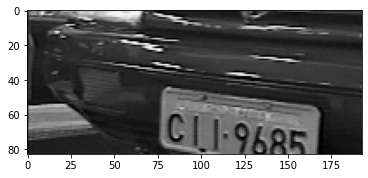

In [85]:
subimage1 = "/content/subimagesTestFolder/0037_192_82_96_131_1.png"

img = cv2.imread(subimage1)
print("original image shape: ", img.shape)

plt.imshow(img)
plt.show()

## **Batch Normalization**

Let Ii(p) = (Ii1(p), Ii2(p), Ii3(p)) be the three color values of each pixel p in the image domain DI of an image Iˆ = (D , I ), i = 1, 2, . . . , N , of the training set. Batch normalization consists of transforming each image Iˆ
iIi i
into an image Jˆ = (D , J ) such that iIi
Jij(p) = Iij(p) − μj(p), (1) σj (p)
 1  N
μj(p) = N Iij(p),
i=1
  1  N
σj(p) =  N − 1
j = 1, 2, 3.
For the testing set, you can only normalize the images by using the parameters μ(p) = (μ1 (p), μ2 (p), μ3 (p))
and σ(p) = (σ1(p),σ2(p),σ3(p)) learned for each pixel p in the training set. Evaluate your results with and without batch normalization.

In [ ]:
#given a folder path with a set of images,
#function that returns the mean and standard deviation
#of the entire set for batch normalization
def returnBatchNormMeanAndStandarDeviationTensor(folderPath):
  meanTensor = 0
  standardDeviationTensor = 0
